In [20]:
# import what we need
import nltk
from nltk.stem.lancaster import LancasterStemmer ## used to stem words
import tensorflow
import random
import json # used to read in json file
stemmer = LancasterStemmer()

import numpy as np
import tensorflow.keras as keras

# printing 
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Generating and printing confusion matrix
import pandas as pd
import seaborn as sn

In [22]:
# load json file
with open("intents.json") as file:
    data = json.load(file)

In [19]:
# need to loop through random training, add each result to seperate list 

predicted = []
actual = []

model_acc = []
times_to_loop = 30

for times in range(times_to_loop):
    
    words = []
    labels = []

    docs_x = []
    docs_y = []

    test_patterns = []

    # loop through dict to grab our values
    for intent in data['intents']:
        rand = random.randint(0, len(intent['patterns'])-1)
        test_pattern = intent['patterns'][rand]
        test_patterns.append(test_pattern)

        for pattern in intent['patterns']:
            if pattern != test_pattern:
                # stemming get the root of word, when traiing model 
                # only care abt the main meaning of word
                # need to tokenize/split words
                wrds = nltk.word_tokenize(pattern)
                words.extend(wrds) ## add all wrds to list
                docs_x.append(wrds)
                # for each pattern add another item in this var to track what tag its part of
                # each entry in docs_x (tokenized words/wrds) will correspond to (intent) docs_y so we know how to classify
                # each of the patterns
                docs_y.append(intent['tag'])

                if intent['tag'] not in labels:
                    labels.append(intent['tag']) # grab all diff tags we need
    
    
    # stem words and remove duplicate words. also lower all words so dont confuse the network into 
    # thinking spelling case has different meaning
    words = [stemmer.stem(w.lower()) for w in words if w!= '?' ] # remove any Question marks, dont want this
    words = sorted(list(set(words)))                             # to have any meaning to our model
    # sort the labels also 
    labels = sorted(labels)
    
    
    # prepare data before we feed into the model 
    # need to convert our text in lists to nums (One-hot-encoding) so our network can 
    # categorize the data
    training = [] # input data goes here 
    output = [] 

    out_empty = [0 for _ in range(len(labels))]

    for x, doc in enumerate(docs_x):

        bag = [] # will be our bag of one hot encoded words
        wrds = [stemmer.stem(w) for w in doc] # stem all the words in patterns

        # go through all diff words in list that are stemmed
        # and add either 1 or 0 to bag of words depending on if this word is in the 
        # main words list "(words = sorted(list(set(words))))"
        for w in words:
            # if word here place 1 representing that word exists
            if w in wrds:
                bag.append(1)
            else:
                # word isn't here place 0
                bag.append(0)

        # now generate output that has either 0's or 1's representing the tag that is word
        output_row = out_empty[:]
        # will look through labels list and check where tag is in list and set that value to 1 
        # in the output_row 
        output_row[labels.index(docs_y[x])] = 1

        # now we have both lists that are now One-hot-encoded !!
        training.append(bag)
        output.append(output_row)
        

    # turn lists into numpy array
    training = np.array(training)
    output = np.array(output)
    
    
    
    
    # Multi-layer net with ReLU hidden layer
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(8,input_dim=training.shape[1],activation='relu',
     bias_initializer=keras.initializers.Constant(0.1)))

    model.add(keras.layers.Dense(8,activation='relu',
     bias_initializer=keras.initializers.Constant(0.1)))

    model.add(keras.layers.Dense(8,activation='relu',
     bias_initializer=keras.initializers.Constant(0.1)))

    model.add(keras.layers.Dense(8,activation='relu',
     bias_initializer=keras.initializers.Constant(0.1)))

    # Output layer (size 6), softmax activation function
    model.add(keras.layers.Dense(output.shape[1],activation='softmax'))
    
    
    
    # Compile as above (default learning rate and other
    # hyperparameters for the Adam optimizer).
    # default learning rate for adam optimizer is 0.001

    model.compile(loss=keras.losses.CategoricalCrossentropy(),
     optimizer=keras.optimizers.Nadam(learning_rate=0.001),
     metrics=[keras.metrics.CategoricalAccuracy()])
    
    
    
    # Train it!
    history = model.fit(training, output,
     batch_size=1,
     epochs=100,
     verbose=0)
    
    # print loss and accuracy from training
    score = model.evaluate(training,output,verbose=1)
    print("printing model.fit stats for loop: ",times + 1)
    print("Loss:",score[0])
    print("Accuracy:",score[1])
    
   

    
    def bag_of_words(s, words):
        bag = [0 for _ in range(len(words))]

        s_words = nltk.word_tokenize(s)
        s_words = [stemmer.stem(word.lower()) for word in s_words]

        for se in s_words:
            for i, w in enumerate(words):
                if w == se:
                    bag[i] = 1

        return np.array(bag)


    
    def run_test(show_successes=True, show_failures=True):
        successes = []
        failures = []

        for i in range(len(test_patterns)):
            results = model.predict(np.array([bag_of_words(test_patterns[i], words)]))[0]

            results_index = np.argmax(results)
            tag = labels[results_index]

            j = 0
            # protect against unknown questions , if model is unsure what user ask they will ask user to rephrase their question 
            if results[results_index] > 0.92:   # the value when the model cant recognize is 0.9133338 so i set this value just above it
                for tg in data["intents"]:
                    if tg['tag'] == tag:
                        responses = tg['responses']
                        predicted.append(j)
                    else:
                        j += 1

                answer = random.choice(responses)

            else:
                answer = 'Answer not found'

            real_tag = data["intents"][i]
            real_responses = real_tag["responses"]

            actual.append(i)

            if answer in real_responses:
                successes.append([test_patterns[i], answer])
            else:
                failures.append([test_patterns[i], answer])

        print("print model.predict stats for loop: ",times + 1)
        print( "Percentage correct: {:.2%}".format(len(successes)/(len(successes)+len(failures))) )
        acc_score = round((len(successes)/(len(successes)+len(failures))),2)
        
        model_acc.append(acc_score)
    
    run_test()
    

5/5 [==============================] - 0s 750us/step - loss: 7.6581e-05 - categorical_accuracy: 1.0000
printing model.fit stats for loop:  1
Loss: 7.658069807803258e-05
Accuracy: 1.0
print model.predict stats for loop:  1
Percentage correct: 33.33%
5/5 [==============================] - 0s 1ms/step - loss: 4.8987e-05 - categorical_accuracy: 1.0000
printing model.fit stats for loop:  2
Loss: 4.8986599722411484e-05
Accuracy: 1.0
print model.predict stats for loop:  2
Percentage correct: 33.33%
5/5 [==============================] - 0s 754us/step - loss: 4.9352e-05 - categorical_accuracy: 1.0000
printing model.fit stats for loop:  3
Loss: 4.9352009227732196e-05
Accuracy: 1.0
print model.predict stats for loop:  3
Percentage correct: 33.33%
5/5 [==============================] - 0s 1ms/step - loss: 1.0785e-04 - categorical_accuracy: 1.0000
printing model.fit stats for loop:  4
Loss: 0.00010785424819914624
Accuracy: 1.0
print model.predict stats for loop:  4
Percentage correct: 47.62%
5/5 [

In [21]:
model_acc

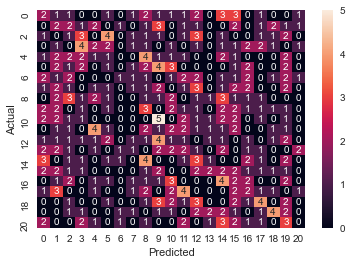

In [23]:
y_actual = pd.Series(actual, name="Actual")
y_predicted = pd.Series(predicted, name="Predicted")
df_confusion = pd.crosstab(y_actual, y_predicted)

sn.heatmap(df_confusion, annot=True)
plt.show()

In [7]:
# A custom function to calculate
# probability distribution function
def pdf(x):
    mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out


In [8]:
x = np.arange(len(model_acc))
y = pdf(x)

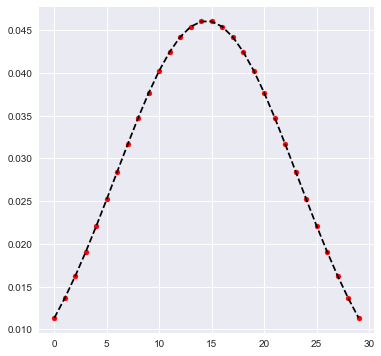

In [9]:
# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x, y, color = 'black',
         linestyle = 'dashed')
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'red')
plt.show()

In [10]:
#  get sum of list of validation scores
total = sum(model_acc)

In [11]:
total

C:\Users\dab7r\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\dab7r\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\dab7r\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was d

In [12]:
# calculate average 
avg = total/len(model_acc)

In [13]:
avg

In [14]:
#calculate standard error of the mean 
SE = np.std(model_acc, ddof=1) / np.sqrt(np.size(model_acc))

In [15]:
# calc Confidence interval for 95% confidence level 
avg + (1.96 * SE) # calc upper confidence limit 

In [16]:
avg - (1.96 * SE) # calc lower confidence limit 